# Experiments

## Setup

In [61]:
using JuMP
using Gurobi
using MathOptInterface
using LinearAlgebra

In [62]:
using CSV
using DataFrames
using Distributions
using Serialization
using Dates

In [63]:
using Distributions
using LinearAlgebra: norm
using BlackBoxOptim
using ProgressMeter

In [64]:
using Gadfly
using Compose
import Cairo, Fontconfig
using Colors, ColorSchemes

In [65]:
output_path = "./results-01/";

## Data

### Parameters

In [66]:
start_date = Date(2021, 12, 15);
end_date = Date(2022, 2, 15);

In [67]:
patient_type = :icu;

### Capacity

In [68]:
capacity_levels = ["baseline", "rampup", "surge", "nextup", "max"];
capacity_names = ["Baseline", "Level 1", "Level 2", "Level 3", "Max"];

In [69]:
function load_capacity(hospitals)
	capacity_df = DataFrame(CSV.File("data/capacity_$(patient_type).csv"))

	sort!(capacity_df, [:hospital_id, :priority])
	capacity_data = map(collect(groupby(capacity_df, :hospital_id))) do df
		h = map(eachrow(df)) do row
			location = findfirst(==(row.hospital_id), hospitals)
			capacity_level = findfirst(==(row.capacity_level), capacity_levels)
			(;location, capacity_level, row.beds, row.priority)
		end
		filter(r -> !isnothing(r.capacity_level), h)
	end

	return capacity_data
end;

In [70]:
alwayszero(x) = 0;

In [71]:
function compute_capacity_params(
		capacity_data;
		cost_setup=alwayszero,
		cost_breakdown=alwayszero,
		cost_convert=alwayszero,
		cost_per_unitday=alwayszero,
		cost_per_bedday=alwayszero,
		time_setup=alwayszero,
		time_breakdown=alwayszero,
	)

	N = length(capacity_data)
	B = [length(capacity_data[i]) for i in 1:N]

	params = map(1:N) do i
		map(1:B[i]) do b
			r = capacity_data[i][b]
			merge(r, (;
				cost_setup = cost_setup(r),
				cost_breakdown = cost_breakdown(r),
				cost_convert = cost_convert(r),
				cost_per_unitday = cost_per_unitday(r),
				cost_per_bedday = cost_per_bedday(r),
				time_setup = time_setup(r),
				time_breakdown = time_breakdown(r),
			))
		end
	end

	return params
end;

### Hospitalization Data

In [72]:
z = deserialize("data/data.jlser")

(realdata = Dict{Any, Any}(:acute => (active = [0 0 … 28 32; 0 0 … 12 10; … ; 0 0 … 23 21; 1 1 … 16 15], admitted = [2.0100992109771448e-6 2.0860925453574057e-6 … 0.8877330398723002 6.879931115779064; 5.674659230851804e-7 9.009760658204652e-7 … 1.9505367436136738 -1.6397764269537873e-5; … ; 2.259602964503384e-6 2.4681669923546667e-6 … 3.023150496433395 0.07483376873855496; 2.2373911186570978e-7 4.595223756323897e-7 … 5.127818713628992 0.13233349500026126]), :combined_flagged => (active = [0 0 … 22 25; 0 0 … 9 7; … ; 0 0 … 13 10; 1 1 … 14 13],), :combined => (active = [0 0 … 32 37; 0 0 … 12 10; … ; 0 0 … 25 22; 1 1 … 17 16], admitted = [0 0 … 5 3; 0 0 … 1 2; … ; 0 0 … 1 3; 0 0 … 5 5]), :meta => (hospitals = ["BMC", "HCGH", "JHH", "SH", "SMH"], date_range = [Date("2020-03-12"), Date("2020-03-13"), Date("2020-03-14"), Date("2020-03-15"), Date("2020-03-16"), Date("2020-03-17"), Date("2020-03-18"), Date("2020-03-19"), Date("2020-03-20"), Date("2020-03-21")  …  Date("2022-07-14"), Date("2022

In [73]:
z[:capacity][:icu]

5×6 Matrix{Int64}:
 12  12   12   12   34   34
 16  16   40   40   40   40
 50  66  148  162  162  289
 12  30   30   30   42   42
 12  12   12   12   24   24

In [74]:
keys(z[:capacity][:icu])

CartesianIndices((5, 6))

In [75]:
function load_data()
	rawdata = deserialize("data/data.jlser")

	hospitals = rawdata.realdata[:meta].hospitals
	dates_all = rawdata.realdata[:meta].date_range

	hospital_names = ["H$i" for i in 1:length(hospitals)]

	dates = filter(d -> start_date <= d <= end_date, dates_all)
	start_date_idx = findfirst(==(start_date), dates_all)
	end_date_idx = findlast(==(end_date), dates_all)
	Topt = collect(start_date_idx:end_date_idx)

	occupancy = rawdata.realdata[:icu].active
	arrivals = rawdata.realdata[:icu].admitted

	occupancy = occupancy[:, 1:end_date_idx]
	arrivals = arrivals[:, 1:end_date_idx]

	N = size(arrivals, 1)
	T = size(arrivals, 2)

	capacity = load_capacity(hospitals)

	return (;
		N, T, Topt,
		start_date, end_date,
		hospitals, hospital_names,
		dates_all, dates_opt=dates,
		occupancy, arrivals,
		capacity,
	)
end;

In [76]:
data = load_data();

## LOS

In [77]:
function estimate_los(admissions, occupancy, Topt)

	function estimate_los_single(adm, occ)

		function unpack_params(params)
			alpha, theta = params
			dist = Gamma(alpha, theta)
			return dist
		end

		function estimate_occupancy_single(adm, los)
			T = length(adm)
			L = pdf.(los, 0:T)
			dis = @views [dot(adm[1:t], L[t:-1:1]) for t in 1:T]
			occ_est = @views [sum(adm[1:t]) - sum(dis[1:t]) for t in 1:T]
			return occ_est
		end

		function score_func(params)
			los_dist = unpack_params(params)
			occ_est = estimate_occupancy_single(adm, los_dist)[Topt]
			score = norm(occ_est - occ, 2)
			return score
		end

		param_bounds = [(0.0,40.0), (0.0,40.0)]
		timelimit = 10.0

		r = bboptimize(
			score_func,
			SearchRange = param_bounds,
			Method = :adaptive_de_rand_1_bin_radiuslimited,
			TraceMode = :silent,
			MaxTime = timelimit,
			RandomizeRngSeed = false,
			RngSeed = 0,
		)

		best_params = best_candidate(r)
		los_dist = unpack_params(best_params)

		return los_dist
	end

	los_dists = Distribution[]
	@showprogress for i in 1:size(admissions,1)
		adm = admissions[i,:]
		occ = occupancy[i,Topt]
		d = estimate_los_single(adm, occ)
		push!(los_dists, d)
	end

	return los_dists
end;

In [78]:
los_dists = estimate_los(data.arrivals, data.occupancy, data.Topt);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


## Model

### Model Parameters

In [79]:
struct TransferBudgets
	perhospitalday::Array{Real,2}
	perhospitalpair::Array{Real,2}
	perday::Array{Real,1}
	perhospital::Array{Real,1}
	total::Real
end;

struct TransferParams
	optimize::Bool
	integer::Bool
	costs::Array{Real,2}
	budgets::TransferBudgets
	transfer_smoothness::Real
	occupancy_smoothness::Real
	admissions_smoothness::Real
end;

struct CapacityParams
	optimize::Bool

	costs_setup::Bool
	costs_breakdown::Bool
	costs_convert::Bool

	costs_bedday::Bool
	costs_unitday::Bool

	ordered::Bool
	baseline_always::Bool
	enforce_leadtime::Bool

	capacity_smoothness::Real
	max_occupancy::Real
end;

struct SolverParams
	timelimit::Real
	verbose::Bool
end;

In [80]:
function TransferBudgets(N, T; perhospitalday=nothing, perhospitalpair=nothing, perday=nothing, perhospital=nothing, total=nothing)
	perhospitalday = isnothing(perhospitalday) ? fill(Inf, (N, T)) : (ndims(perhospitalday) == 1) ? repeat(perhospitalday, 1, T) : perhospitalday
	perhospitalpair = isnothing(perhospitalpair) ? fill(Inf, (N, N)) : perhospitalpair
	perday = isnothing(perday) ? fill(Inf, T) : (perday isa Array) ? perday : fill(perday, T)
	perhospital = isnothing(perhospital) ? fill(Inf, N) : perhospital
	total = isnothing(total) ? Inf : total
	return TransferBudgets(perhospitalday, perhospitalpair, perday, perhospital, total)
end;

function TransferParams(N, T; optimize=true, integer=true, costs=nothing, budgets=nothing, transfer_smoothness=0, occupancy_smoothness=0, admissions_smoothness=0)
	costs = isnothing(costs) ? fill(0, (N, N)) : (costs isa Array) ? costs : fill(costs, (N, N))
	budgets = isnothing(budgets) ? TransferBudgets(N, T) : budgets
	return TransferParams(optimize, integer, costs, budgets, transfer_smoothness, occupancy_smoothness, admissions_smoothness)
end;

function CapacityParams(;optimize=true, costs_setup=false, costs_breakdown=false, costs_convert=false, costs_bedday=false, costs_unitday=false, ordered=false, baseline_always=false, enforce_leadtime=false, capacity_smoothness=0, max_occupancy=1)
	return CapacityParams(optimize, costs_setup, costs_breakdown, costs_convert, costs_bedday, costs_unitday, ordered, baseline_always, enforce_leadtime, capacity_smoothness, max_occupancy)
end;

function SolverParams(;timelimit=Inf, verbose=false)
	return SolverParams(timelimit, verbose)
end;

### Model Helpers

In [81]:
function discretize_los(los::Array{<:Distribution,1}, N::Int, T::Int)
	L = [pdf(l, t) for l in los, t in 0:T]
	return L
end;

In [82]:
function unpack_decisions(model)
	N = model[:N]
	Topt = model[:Topt]
	B = model[:B]

	capacity = Array(value.(model[:capacity]))
	admissions = value.(model[:admissions])[:,Topt]
	occupancy = value.(model[:occupancy])[:,Topt]

	if haskey(model, :transfers)
		transfers = Array(value.(model[:transfers]))
	else
		transfers = zeros(Int, N, N, length(Topt))
	end

	# capacity_unit_allocated_ = value.(model[:capacity_unit_allocated])
	capacity_unit_allocated_ = value.(model[:capacity_unit_usable])
	capacity_unit_allocated = [[capacity_unit_allocated_[i,t,b] for b in 1:B[i]] for i in 1:N, t in Topt]

	return (;transfers, capacity, capacity_unit_allocated, admissions, occupancy)
end;

In [83]:
function set_model_params!(model, params)
	for (k,v) in pairs(params)
		model[k] = v
	end
	return model
end;

### Model

In [84]:
function optimize_decisions(
		arrivals::Array{<:Real,2},
		capacity::Array,
		los::Array{<:Distribution,1},
		Topt::Array{Int,1},
		capacity_params::CapacityParams,
		transfer_params::TransferParams,
		solver_params::SolverParams,
	)

	N, T = size(arrivals)
	B = [length(capacity[i]) for i in 1:N]

	L = discretize_los(los, N, T)

	# create model
	model = Model(Gurobi.Optimizer)
	if !solver_params.verbose set_silent(model) end
	if (solver_params.timelimit > 0) set_time_limit_sec(model, solver_params.timelimit) end
	set_model_params!(model, (;N, T, B, Topt))

	objective = @expression(model, AffExpr(0))

	# subproblems
	if transfer_params.optimize
		model, transfers_objective = transfers_subproblem(model, arrivals, L, transfer_params)
		objective += transfers_objective
	end
	if capacity_params.optimize
		model, capacity_objective = capacity_subproblem(model, arrivals, capacity, L, capacity_params)
		objective += capacity_objective
	end

	# objective
	@objective(model, Min, objective)

	# solve
	optimize!(model)

	return model
end;

#### Capacity Allocation

In [85]:
function capacity_subproblem(model, arrivals, capacity_data, L, params)
	N = model[:N]
	T = model[:T]
	Topt = model[:Topt]
	B = model[:B]

	# occupancy
	if !haskey(model, :occupancy)
		@expression(model, discharges[i=1:N, t=1:T], dot(arrivals[i,1:t], L[i,t:-1:1]))
		@expression(model, occupancy[i=1:N, t=1:T], sum(arrivals[i,1:t]) - sum(discharges[i,1:t]))
		model[:admissions] = arrivals
	else
		occupancy = model[:occupancy]
	end

	# decision variables
	# @variable(model, capacity_unit_allocated[i=1:N, Topt, 1:B[i]], Bin)

	# lead time
	if params.enforce_leadtime
		@variable(model, capacity_unit_allocated[i=1:N, Topt, 1:B[i]], Bin)
		@variable(model, capacity_unit_usable[i=1:N, Topt, 1:B[i]], Bin)

		st = [[capacity_data[i][b].time_setup for b in 1:B[i]] for i in 1:N]
		bt = [[capacity_data[i][b].time_breakdown for b in 1:B[i]] for i in 1:N]
		beds = [[capacity_data[i][b].beds for b in 1:B[i]] for i in 1:N]
		tmin, tmax = extrema(Topt)

		# @constraint(model, [i=1:N, t in Topt, b=1:B[i]], capacity_unit_usable[i,t,b] ≤ capacity_unit_allocated[i,max(tmin,t-st[i][b]),b])
		# @constraint(model, [i=1:N, t in Topt, b=1:B[i]], capacity_unit_usable[i,t,b] ≤ capacity_unit_allocated[i,min(tmax,t+bt[i][b]),b])
		# @constraint(model, [i=1:N, t in Topt, b=1:B[i]], capacity_unit_usable[i,t,b] ≤ capacity_unit_allocated[i,t,b])

		@constraint(model, [i=1:N, t in Topt, b=1:B[i], z=0:st[i][b]], capacity_unit_usable[i,t,b] ≤ capacity_unit_allocated[i,max(tmin,t-z),b])
		@constraint(model, [i=1:N, t in Topt, b=1:B[i], z=0:bt[i][b]], capacity_unit_usable[i,t,b] ≤ capacity_unit_allocated[i,min(tmax,t+z),b])
		# @constraint(model, [i=1:N, t in Topt, b=1:B[i]], capacity_unit_usable[i,t,b] ≥ capacity_unit_allocated[i,t,b])

		# @expression(model, capacity_usable[i=1:N, t in Topt], sum(capacity_unit_usable[i,t,b] * capacity_data[i][b].beds for b in 1:B[i]))
		@expression(model, capacity_usable[i=1:N, t in Topt], dot(capacity_unit_usable[i,t,:], beds[i]))
	else
		@variable(model, capacity_unit_usable[i=1:N, Topt, 1:B[i]], Bin)
		@expression(model, capacity_unit_allocated[i=1:N, t in Topt, b=1:B[i]], capacity_unit_usable[i,t,b])
	end

	# capacity
	@expression(model, capacity[i=1:N, t=Topt], sum(capacity_unit_usable[i,t,b] * capacity_data[i][b].beds for b in 1:B[i]))
	@constraint(model, [i=1:N, t in Topt], capacity[i,t] ≥ occupancy[i,t])

	# maximum occupancy rate
	if params.max_occupancy < 1
		@constraint(model, [i=1:N, t in Topt], params.max_occupancy * capacity[i,t] ≥ occupancy[i,t])
	end

	# order constraint
	if params.ordered
		@constraint(model, [i=1:N, t in Topt, b=2:B[i]], capacity_unit_usable[i,t,b] ≤ capacity_unit_usable[i,t,b-1])
	end

	if params.baseline_always
		capacity_levels = [[b.capacity_level for b in h] for h in capacity_data]
		Bbaseline = [findall(==(1), h) for h in capacity_levels]
		@constraint(model, [i=1:N, t in Topt, b in Bbaseline[i]], capacity_unit_usable[i,t,b] == 1)
	end

	obj = compute_capacity_objective(model, capacity_data, params)

	return model, obj
end;

In [86]:
function compute_capacity_objective(model, capacity_costs, params)
	objective = @expression(model, AffExpr(0))

	N = model[:N]
	Topt = model[:Topt]
	B = model[:B]

	capacity = model[:capacity].data
	capacity_unit_allocated = model[:capacity_unit_allocated]

	if params.costs_unitday
		for i in 1:N, b in 1:B[i]
			if capacity_costs[i][b].cost_per_unitday > 0
				add_to_expression!(objective, capacity_costs[i][b].cost_per_unitday * sum(capacity_unit_allocated[i,:,b]))
			end
		end
	end

	if params.costs_bedday
		error()
	end

	# capacity setup
	if params.costs_setup
		@variable(model, capacity_unit_setup[i=1:N, Topt, 1:B[i]], Bin)
		@constraint(model, [i=1:N, t in Topt[2:end], b=1:B[i]], capacity_unit_setup[i,t,b] ≥ capacity_unit_allocated[i,t,b] - capacity_unit_allocated[i,t-1,b])
		@constraint(model, [i=1:N, t in Topt[1:1], b=1:B[i]], capacity_unit_setup[i,t,b] == 1)

		for i in 1:N, b in 1:B[i]
			add_to_expression!(objective, capacity_costs[i][b].cost_setup * sum(capacity_unit_setup[i,:,b]))
		end
	end

	# capacity breakdown
	if params.costs_breakdown
		@variable(model, capacity_unit_breakdown[i=1:N, Topt, 1:B[i]], Bin)
		@constraint(model, [i=1:N, t in Topt[2:end], b=1:B[i]], capacity_unit_breakdown[i,t,b] ≥ capacity_unit_allocated[i,t,b] - capacity_unit_allocated[i,t+1,b])
		@constraint(model, [i=1:N, t in Topt[1:1], b=1:B[i]], capacity_unit_breakdown[i,t,b] == 0)

		for i in 1:N, b in 1:B[i]
			add_to_expression!(objective, capacity_costs[i][b].cost_breakdown * sum(capacity_unit_breakdown[i,:,b]))
		end
	end

	# capacity converted (setup/breakdown)
	if params.costs_convert
		@variable(model, capacity_unit_converted[i=1:N, Topt, 1:B[i]], Bin)
		@constraint(model, [i=1:N, t in Topt[2:end], b=1:B[i]], capacity_unit_converted[i,t,b] ≥ capacity_unit_allocated[i,t,b] - capacity_unit_allocated[i,t-1,b])
		@constraint(model, [i=1:N, t in Topt[2:end], b=1:B[i]], capacity_unit_converted[i,t,b] ≥ capacity_unit_allocated[i,t-1,b] - capacity_unit_allocated[i,t,b])
		@constraint(model, [i=1:N, t in Topt[1:1], b=1:B[i]], capacity_unit_converted[i,t,b] == 1)
		
		for i in 1:N, b in 1:B[i]
			add_to_expression!(objective, capacity_costs[i][b].cost_convert * sum(capacity_unit_converted[i,:,b]))
		end
	end

	if params.capacity_smoothness > 0
		T = length(model[:Topt])
		@variable(model, capacity_smoothness_penalties[1:N,1:(T-1)] ≥ 0)
		@constraint(model, [i=1:N, t=1:(T-1)], capacity_smoothness_penalties[i,t] >= capacity[i,t] - capacity[i,t+1])
		@constraint(model, [i=1:N, t=1:(T-1)], capacity_smoothness_penalties[i,t] >= capacity[i,t+1] - capacity[i,t])
		add_to_expression!(objective, capacity_costs.capacity_smoothness * sum(capacity_smoothness_penalties))
	end

	return objective
end;

#### Patient Transfers

In [87]:
function transfers_subproblem(model, arrivals, L, params)
	N = model[:N]
	T = model[:T]
	Topt = model[:Topt]

	# decision variables
	@variable(model, transfers[1:N, 1:N, Topt] ≥ 0, integer=params.integer)

	# auxillary
	@expression(model, transfers_[i=1:N, j=1:N, t=1:T], (t ∈ Topt) ? transfers[i,j,t] : 0)

	# occupancy
	@expression(model, admissions[i=1:N, t=1:T], arrivals[i,t] + sum(transfers_[:,i,t]) - sum(transfers_[i,:,t]))
	@expression(model, discharges[i=1:N, t=1:T], dot(admissions[i,1:t], L[i,t:-1:1]))
	@expression(model, occupancy[i=1:N, t=1:T], sum(admissions[i,1:t]) - sum(discharges[i,1:t]))

	# transfer constraint
	@constraint(model, [i=1:N, t in Topt], sum(transfers[i,:,t]) ≤ arrivals[i,t])

	# transfer budgets
	add_transfer_budget!(model, params.budgets)

	# objective
	obj = compute_transfer_objective(model, params)

	return model, obj
end;

In [88]:
function compute_transfer_objective(model, params)
	objective = @expression(model, AffExpr(0))

	N = model[:N]
	T = length(model[:Topt])

	if any(params.costs .!= 0)
		transfers = model[:transfers].data
		add_to_expression!(objective, dot(params.costs, sum(transfers, dims=3)))
	end

	if params.transfer_smoothness > 0
		transfers = model[:transfers].data
		@variable(model, transfer_smoothness_penalties[i=1:N,j=i:N,1:(T-1)] ≥ 0)
		@constraint(model, [i=1:N, j=i:N, t=1:(T-1)], transfer_smoothness_penalties[i,j,t] >= transfers[i,j,t] - transfers[i,j,t+1])
		@constraint(model, [i=1:N, j=i:N, t=1:(T-1)], transfer_smoothness_penalties[i,j,t] >= transfers[i,j,t+1] - transfers[i,j,t])
		add_to_expression!(objective, params.transfer_smoothness * sum(transfer_smoothness_penalties))
	end

	if params.occupancy_smoothness > 0
		occupancy = model[:occupancy].data
		@variable(model, occupancy_smoothness_penalties[1:N,1:(T-1)] ≥ 0)
		@constraint(model, [i=1:N, t=1:(T-1)], occupancy_smoothness_penalties[i,t] >= occupancy[i,t] - occupancy[i,t+1])
		@constraint(model, [i=1:N, t=1:(T-1)], occupancy_smoothness_penalties[i,t] >= occupancy[i,t+1] - occupancy[i,t])
		add_to_expression!(objective, params.occupancy_smoothness * sum(occupancy_smoothness_penalties))
	end

	if params.admissions_smoothness > 0
		admissions = model[:admissions].data
		@variable(model, admissions_smoothness_penalties[1:N,1:(T-1)] ≥ 0)
		@constraint(model, [i=1:N, t=1:(T-1)], admissions_smoothness_penalties[i,t] >= admissions[i,t] - admissions[i,t+1])
		@constraint(model, [i=1:N, t=1:(T-1)], admissions_smoothness_penalties[i,t] >= admissions[i,t+1] - admissions[i,t])
		add_to_expression!(objective, params.admissions_smoothness * sum(admissions_smoothness_penalties))
	end

	return objective
end;

In [89]:
function add_transfer_budget!(model, transferbudget)
	N = model[:N]
	Topt = model[:Topt]
	transfers = model[:transfers]

	notinf(x) = !isinf(x)
	if any(notinf.(transferbudget.perhospitalpair))
		@constraint(model, [i=1:N, j=1:N, t in Topt], transfers[i,j,t] ≤ transferbudget.perhospitalpair[i,j])
	end
	if any(notinf.(transferbudget.perhospital))
		@constraint(model, [i=1:N, t in Topt], sum(transfers[i,:,t]) ≤ transferbudget.perhospital[i])
	end
	if notinf(transferbudget.total)
		@constraint(model, [i=1:N, j=1:N, t in Topt], sum(transfers) ≤ transferbudget.total)
	end

	return model
end;

## Output Processing

In [90]:
function compute_metrics(data, results)
	N, _, T = size(results.transfers)

    metrics_total = (;
        hospitals = length(data.hospitals),
        days = length(data.dates_opt),
        transfers = sum(results.transfers),
        occupancy = sum(results.occupancy),
        admissions = sum(results.admissions),
        allocated_capacity = sum(results.capacity),
    )

	metrics_byhospital = DataFrame([
		(
			hospital = data.hospitals[i],
			hospital_name = data.hospital_names[i],
			# base_capacity = data.capacity_perlevel[i,1],
			# admissions = sum(results.admissions[i,:]),
			transfers_out = sum(results.transfers[i,:,:]),
			transfers_in = sum(results.transfers[:,i,:]),
			# maxload = maximum(results.occupancy[i,:] ./ data.capacity_perlevel[i,1]),
		)
		for i in 1:N
	])

	metrics_bydate = DataFrame([
		(
			date = data.start_date + Day(t-1),
			occupancy = sum(results.occupancy[:,t]),
			# load = sum(data.occupancy_notfr[:,t]) ./ sum(data.capacity_perlevel[:,1]),
			admissions = sum(results.admissions[:,t]),
			transfers = sum(results.transfers[:,:,t]),
		)
		for t in 1:T
	])

	metrics_byhospitalday = DataFrame([
		(
			hospital = data.hospitals[i],
			hospital_name = data.hospital_names[i],
			date = data.dates_opt[t],
			# capacity_baseline = data.capacity_perlevel[i,1],
			# arrivals = data.arrivals[i,t],
			admissions = results.admissions[i,t],
			transfers_out = sum(results.transfers[i,:,t]),
			transfers_in = sum(results.transfers[:,i,t]),
			# shortage = max(results.occupancy[i,t] - data.capacity_perlevel[i,1], 0),
			# load = results.occupancy[i,t] / data.capacity_perlevel[i,1],
			occupancy = results.occupancy[i,t],
			capacity = results.capacity[i,t],
			# capacity_level = results.capacity_level[i,t],
		)
		for i in 1:N, t in 1:T
	][:])

	return (;
        total = metrics_total,
		byhospital = metrics_byhospital,
		bydate = metrics_bydate,
		byhospitalday = metrics_byhospitalday,
		# summary = get_summary(data),
	)
end;

## Visualization

### Vis Utils

In [91]:
defaultfont = "Helvetica";
fontstyles = (
	key_title_font = defaultfont,
	key_label_font = defaultfont,
	minor_label_font = defaultfont,
	major_label_font = defaultfont,
	point_label_font = defaultfont,
	key_title_font_size = 14px,
	key_label_font_size = 13px,
	minor_label_font_size = 14px,
	major_label_font_size = 16px,
	point_label_font_size = 12px,
);

In [92]:
function halfmonth(d::Date)
    x = dayofmonth(d)
    if x < 15
        return firstdayofmonth(d)
    else
        return firstdayofmonth(d)+Day(14)
    end
end;

In [93]:
date_ticks = begin
    ds = collect(start_date:Day(1):end_date)
    ds = halfmonth.(ds)
    ds = unique(ds)
    DateTime.(ds)
end

5-element Vector{DateTime}:
 2021-12-15T00:00:00
 2022-01-01T00:00:00
 2022-01-15T00:00:00
 2022-02-01T00:00:00
 2022-02-15T00:00:00

In [94]:
function savefig(plt, size, output_path, folder, filename)
    @assert !isnothing(folder)

    output_path_eps = joinpath(output_path, "eps/", folder, filename * ".eps")
    output_path_pdf = joinpath(output_path, "pdf/", folder, filename * ".pdf")
    output_path_png = joinpath(output_path, "png/", folder, filename * ".png")

    mkpath(dirname(output_path_eps))
    mkpath(dirname(output_path_pdf))
    mkpath(dirname(output_path_png))

    plt |> PS(output_path_eps , size...)
    plt |> PDF(output_path_pdf, size...)
    plt |> PNG(output_path_png, size..., dpi=250)

    return
end;

### Plots

In [95]:
function plot_capacity(data, results, metrics; show=false, save=false, folder=nothing)
	plt = plot(
		metrics.byhospitalday,
		x = :date,
		y = :capacity,
		color = :hospital_name,

		Geom.line,
		# Geom.point,

		# Guide.title("Required COVID-19 ICU Capacity by Hospital"),
		Guide.xlabel(""),
		Guide.ylabel("COVID-19 ICU Capacity"),
		Guide.colorkey(title="Hospital"),

		Coord.cartesian(ymin=0, xmin=date_ticks[1], xmax=date_ticks[end]),

		Guide.xticks(ticks=date_ticks),
		Scale.x_continuous(labels=(d -> Dates.format(d, "u d, Y"))),

		Scale.y_continuous(format=:plain),
		# Scale.y_continuous(labels=(x->"")),

		layer(
			yintercept=[0],
			xintercept=[date_ticks[1]],
			Geom.hline(color="lightgrey", size=0.6mm),
			Geom.vline(color="lightgrey", size=0.6mm),
		),

		style(
			# grid_line_width=0.4mm,
			# grid_color=colorant"lightgray",
			# grid_line_style=:solid,
			# key_position=:none,
			line_width=0.55mm,
			background_color=colorant"white",
			plot_padding=[5mm, 10mm, 5mm, 5mm];
			fontstyles...,
		),
	)

    plt_size = (20cm, 10cm)

	if show
		plt |> SVG(plt_size...)
	end
	if save
        savefig(plt, plt_size, output_path, folder, "capacity")
	end

	return plt, plt_size
end;

In [96]:
function plot_load(data, results, metrics, capacity_level; show=false, save=false, folder=nothing)
	start_date, end_date = data.start_date, data.end_date

	metrics_df = select(metrics.byhospitalday, :hospital, :hospital_name, :date, :occupancy, :capacity)

	if capacity_level == :dynamic
		metrics_df.load_l = metrics_df.occupancy ./ metrics_df.capacity
	else
		capacity_l_data = [filter(r -> r.capacity_level <= capacity_level, h) for h in data.capacity]
		capacity_l = [sum([r.beds for r in h]) for h in capacity_l_data]

		hosp_idx_lookup = Dict(zip(data.hospitals, 1:data.N))
		metrics_df.hospital_idx = map(h -> hosp_idx_lookup[h], metrics_df.hospital)
		metrics_df.capacity_l = map(h -> capacity_l[h], metrics_df.hospital_idx)
		metrics_df.load_l = metrics_df.occupancy ./ metrics_df.capacity_l
	end

	ylabel = (capacity_level == 1) ? "Baseline Capacity Utilization" : "Occupancy"

	# load_plot_max = 2.0
	# load_plot_max = 2.5
	load_plot_max = max(2.0, maximum(metrics_df.load_l))

	plt = plot(
		layer(
			metrics_df,
			x = :date,
			y = :load_l,
			color = :hospital_name,
			Geom.line,
		),

		Guide.xlabel(""),
		# Guide.ylabel("Capacity Utilization (%)"),
		# Guide.ylabel("Capacity Utilization"),
		Guide.ylabel(ylabel),
		# Guide.title("COVID-19 ICU Patient Load"),

		layer(ymin=[0.0], ymax=[1.0],           Geom.hband, alpha=[0.1], style(default_color=colorant"green"), order=-1),
		layer(ymin=[1.0], ymax=[load_plot_max], Geom.hband, alpha=[0.1], style(default_color=colorant"red"),   order=-1),

		Coord.cartesian(ymin=0, ymax=load_plot_max, xmin=date_ticks[1], xmax=date_ticks[end]),

		Guide.xticks(ticks=date_ticks),
		Scale.x_continuous(labels=(d -> Dates.format(d, "u d, Y"))),

		Scale.y_continuous(labels=x -> "$(round(Int, x*100))%"),

		style(
			background_color=colorant"white",
			plot_padding=[5mm, 10mm, 5mm, 5mm],
			key_position=:none;
			fontstyles...,
		),
	)

    plt_size = (18cm, 10cm)

	if show
		plt |> SVG(plt_size...)
	end
	if save
        savefig(plt, plt_size, output_path, folder, "load_$(capacity_level)")
	end

	return plt, plt_size
end;

In [97]:
function plot_system_load(data, results, metrics, capacity_level, show_all; show=false, save=false, folder=nothing)

	system_df = combine(
		groupby(metrics.byhospitalday, :date),
		:occupancy => sum => :occupancy,
		:capacity => sum => :capacity,
	)

	if capacity_level == :dynamic
		system_df.load_l = system_df.occupancy ./ system_df.capacity
	else
		capacity_l_data = [filter(r -> r.capacity_level <= capacity_level, h) for h in data.capacity]
		capacity_l = [sum([r.beds for r in h]) for h in capacity_l_data]
		capacity_l = sum(capacity_l)
		system_df.capacity_l = fill(capacity_l, nrow(system_df))
		system_df.load_l = system_df.occupancy ./ capacity_l
	end

	metrics_df = select(metrics.byhospitalday, :hospital, :hospital_name, :date, :occupancy, :capacity)

	if capacity_level == :dynamic
		metrics_df.load_l = metrics_df.occupancy ./ metrics_df.capacity
	else
		capacity_l_data = [filter(r -> r.capacity_level <= capacity_level, h) for h in data.capacity]
		capacity_l = [sum([r.beds for r in h]) for h in capacity_l_data]

		hosp_idx_lookup = Dict(zip(data.hospitals, 1:data.N))
		metrics_df.hospital_idx = map(h -> hosp_idx_lookup[h], metrics_df.hospital)
		metrics_df.capacity_l = map(h -> capacity_l[h], metrics_df.hospital_idx)
		metrics_df.load_l = metrics_df.occupancy ./ metrics_df.capacity_l
	end

	sort!(metrics_df, [:hospital_name, :date])
	hospitals = sort(unique(metrics_df.hospital_name))

	ylabel = (capacity_level == 1) ? "Baseline Capacity Utilization" : "Occupancy"

	# load_plot_max = 2.5
	load_plot_max = max(1.25, maximum(metrics_df.load_l))

	indiv_layer = if show_all
		layer(
			metrics_df,
			x = :date,
			y = :load_l,
			color = :hospital_name,
			Geom.line,
			style(line_width=0.25mm),
			order=-100,
		)
	else
		load_plot_max = 1.2
		Guide.yticks(ticks=0:0.2:1.2)
	end

	colorkey = if show_all
		labels = ["System"; hospitals]
		keycolors = [colorant"navy"; Scale.default_discrete_colors(length(hospitals))]
		Guide.manual_color_key("", labels, keycolors)
	else
		style()
	end

	plt = plot(
		layer(
			system_df,
			x = :date,
			y = :load_l,
			Geom.point,
			Geom.line,
			style(
				line_width=0.7mm,
				default_color=colorant"navy",
			),
			order=100,
		),

		layer(
			yintercept = [1.0],
			Geom.hline(color="red", size=0.8mm),
			order=0,
		),
		layer(
			yintercept = [0.95],
			Geom.hline(color="gold", size=0.8mm),
			order=0,
		),

		indiv_layer,

		Guide.xticks(ticks=date_ticks),
		Scale.x_continuous(labels=(d -> Dates.format(d, "u d, Y"))),

		Scale.y_continuous(format=:plain),
		Scale.y_continuous(labels=x -> "$(round(Int, x*100))%"),

		Guide.xlabel(""),
		# Guide.ylabel("Capacity Utilization"),
		Guide.ylabel(ylabel),

		colorkey,

		Coord.cartesian(ymin=0, ymax=load_plot_max, xmin=date_ticks[1], xmax=date_ticks[end]),

		style(
			background_color=colorant"white",
			colorkey_swatch_shape=:square,
			plot_padding=[5mm, 10mm, 5mm, 5mm],
			key_position=:none;
			fontstyles...,
		),
	)

    plt_size = (20cm, 10cm)

	if show
		plt |> SVG(plt_size...)
	end
	if save
        savefig(plt, plt_size, output_path, folder, "system_load_$(capacity_level)")
	end

	return plt, plt_size
end;

In [98]:
function plot_unit_usage(data, results, metrics, h_idx, binary; show=false, save=false, folder=nothing)
	B = length(data.capacity[h_idx])

	if h_idx == 3
		B = length([h for h in data.capacity[h_idx] if h.capacity_level < 4])
	end

	usage = results.capacity_unit_allocated[h_idx,:]
	usage_df = allcombinations(DataFrame, :unit => 1:B, :day => 1:length(usage))
	usage_df.date = map(d -> data.dates_opt[d], usage_df.day)

	if binary
		usage_df.allocated = map(r -> max(usage[r.day][r.unit], 0), eachrow(usage_df))
		sort!(usage_df, :allocated)
	else
		usage_df.allocated = map(r -> (usage[r.day][r.unit] > 0) ? data.capacity[h_idx][r.unit].beds : 0, eachrow(usage_df))
	end

	if binary
		colorscale = Scale.color_discrete_manual(colorant"gray95", colorant"deepskyblue")
		colorkey = Guide.colorkey(title="", labels=["Not Used", "Used"])
	else
		max_z = maximum(b.beds for b in data.capacity[h_idx])
		cmap = ColorScheme(range(colorant"white", colorant"deepskyblue", length=100))
		cmap_fn = z -> (z == 0) ? colorant"gray95" : cmap[0.75*z + 0.25]
		colorscale = Scale.color_continuous(colormap=cmap_fn)
		colorkey = Guide.colorkey(title="Beds")
	end

	yticks = if B < 10
		1:B
	elseif B < 50
		z = collect(0:5:B)
		z[1] = 1
		z
	else
		z = collect(0:10:B)
		z[1] = 1
		z
	end

	levels = unique(b.capacity_level for b in data.capacity[h_idx])
	level_inds = [findlast(b -> b.capacity_level == c, data.capacity[h_idx]) for c in levels]
	level_inds = [i for i in level_inds if !isnothing(i)]
	level_inds = isempty(level_inds) ? [-1] : level_inds
	level_names = [capacity_names[l] for l in levels]

	plt = plot(
		usage_df,
		x = :date,
		y = :unit,
		color = :allocated,
		Geom.rectbin,

		layer(
			yintercept = (level_inds .+ 0.5),
			Geom.hline(color="gray", size=3px),

			x = [data.dates_opt[end] for _ in level_inds],
			y = [y+0.45-(0.03B) for y in level_inds],
			label = level_names,
			Geom.label(position=:left),

			order=100,
		),

		Guide.xlabel(""),
		Guide.ylabel("Unit ID (H$(h_idx))"),
		Guide.title("H$(h_idx)"),

		colorkey,
		colorscale,

		Guide.xticks(ticks=date_ticks),
		Scale.x_continuous(labels=(d -> Dates.format(d, "u d, Y"))),

		Coord.cartesian(ymin=0.5, ymax=B+0.5),
		Guide.yticks(ticks=yticks),

		style(
			background_color=colorant"white",
			plot_padding=[5mm, 5mm, 5mm, 5mm];
			fontstyles...,
			key_label_font_size=14px,
			# point_label_color=colorant"gray",
		),
	)

    plt_size = (24cm, 10cm)

	if show
		plt |> SVG(plt_size...)
	end
	if save
        savefig(plt, plt_size, output_path, folder, "unit_usage_$(h_idx)")
	end

	return plt, plt_size
end;

In [99]:
function plot_surge_timeline(data, results, metrics; show=false, save=false, folder=nothing)
	if !haskey(results, :surge_level)
		max_alloc_timeline = map(z -> findlast(>(0),z), results.capacity_unit_allocated)
		capacity_levels = [[b.capacity_level for b in h] for h in data.capacity]
		capacity_timeline = [capacity_levels[i][max_alloc_timeline[i,t]] for i in 1:data.N, t in 1:length(data.Topt)]
	else
		# capacity_levels = results.capacity_by_surgelevel
		# capacity_timeline = [capacity_levels[i, results.surge_level[i,t]] for i in 1:data.N, t in 1:length(data.Topt)]
		capacity_timeline = results.surge_level
	end

	timeline_df = DataFrame(
		hospital = repeat(data.hospital_names, 1, length(data.Topt))[:],

		date = permutedims(repeat(data.dates_opt, 1, data.N), (2,1))[:],
		date_offset = permutedims(repeat(data.dates_opt, 1, data.N), (2,1))[:] .+ Day(1),

		capacity_level = capacity_timeline[:],

		H0 = fill(0, data.N * length(data.Topt)),
		H1 = fill(1, data.N * length(data.Topt)),
	)

	C = maximum(timeline_df.capacity_level)
	capacity_colors = [colorant"rgb(39,123,70)", colorant"yellow", colorant"gold", colorant"red", colorant"purple", colorant"black"][1:C]

	plt = plot(
		timeline_df,
		xmin = :date,
		xmax = :date_offset,
		ymin = :H0,
		ymax = :H1,
		ygroup = :hospital,
		color = :capacity_level,
		Geom.subplot_grid(
			layer(Geom.rect),
			Guide.yticks(ticks=[0]),
			Guide.xticks(ticks=date_ticks),
		),

		Guide.xlabel(""),
		Guide.ylabel("Hospital"),
		Guide.colorkey(title="Surge Level", labels=capacity_names[1:C]),

		Scale.color_discrete_manual(capacity_colors..., levels=1:C),

		Scale.x_continuous(labels=(d -> Dates.format(d, "u d, Y"))),
		Scale.y_continuous(labels=(x -> "")),

		style(
			background_color=colorant"white",
			plot_padding=[8mm, 5mm, 5mm, 5mm];
			fontstyles...,
			key_label_font_size=14px,
		),
	)

    plt_size = (24cm, 10cm)

	if show
		plt |> SVG(plt_size...)
	end
	if save
        savefig(plt, plt_size, output_path, folder, "surge_timeline")
	end

	return plt, plt_size
end;

In [100]:
function plot_surge_timeline_alt(data, results)
	max_alloc_timeline = map(z -> findlast(>(0),z), results.capacity_unit_allocated)
	capacity_levels = [[b.capacity_level for b in h] for h in data.capacity]
	capacity_timeline = [capacity_levels[i][max_alloc_timeline[i,t]] for i in 1:data.N, t in 1:length(data.Topt)]

	timeline_df = DataFrame(
		hospital = repeat(data.hospital_names, 1, length(data.Topt))[:],
		date = permutedims(repeat(data.dates_opt, 1, data.N), (2,1))[:],
		capacity_level = capacity_timeline[:],
	)

	C = maximum(timeline_df.capacity_level)
	capacity_colors = [colorant"rgb(39,123,70)", colorant"yellow", colorant"gold", colorant"red", colorant"purple", colorant"black"][1:C]

	plt = plot(
		timeline_df,
		x = :date,
		y = :hospital,
		color = :capacity_level,
		Geom.rectbin,

		Guide.xlabel(""),
		Guide.ylabel("Hospital"),
		Guide.colorkey(title="Surge Level", labels=capacity_names[1:C]),

		Scale.color_discrete_manual(capacity_colors..., levels=1:C),

		Guide.xticks(ticks=date_ticks),
		Scale.x_continuous(labels=(d -> Dates.format(d, "u d, Y"))),

		style(
			background_color=colorant"white",
			plot_padding=[5mm, 5mm, 5mm, 5mm];
			fontstyles...,
			key_label_font_size=14px,
		),
	)

	plt |> SVG(24cm, 10cm)

	return plt
end;

## Results

### Helper

In [101]:
function run_experiment(
		exp_id,
		capacity_cost_fns,
		capacity_params,
		transfer_params,
		solver_params;
		show = true,
	)

	data = load_data()
	capacity_cost_params = compute_capacity_params(data.capacity; capacity_cost_fns...)

	model = optimize_decisions(
		data.arrivals,
		capacity_cost_params,
		los_dists,
		data.Topt,
		capacity_params,
		transfer_params,
		solver_params,
	)

	results = unpack_decisions(model)
	metrics = compute_metrics(data, results)

	plot_capacity(data, results, metrics, show=show, save=true, folder=exp_id)

	plot_load(data, results, metrics, 1, show=show, save=true, folder=exp_id)
	plot_load(data, results, metrics, :dynamic, show=show, save=true, folder=exp_id)

	plot_system_load(data, results, metrics, 1, false, show=false, save=false, folder=exp_id)
	plot_system_load(data, results, metrics, :dynamic, false, show=false, save=false, folder=exp_id)

	plot_system_load(data, results, metrics, 1, true, show=show, save=true, folder=exp_id)
	plot_system_load(data, results, metrics, :dynamic, true, show=show, save=true, folder=exp_id)

	plot_surge_timeline(data, results, metrics, show=show, save=true, folder=exp_id)

	plot_unit_usage(data, results, metrics, 1, false, show=show, save=true, folder=exp_id)
	plot_unit_usage(data, results, metrics, 2, false, show=false, save=true, folder=exp_id)
	plot_unit_usage(data, results, metrics, 3, false, show=show, save=true, folder=exp_id)
	plot_unit_usage(data, results, metrics, 4, false, show=false, save=true, folder=exp_id)
	plot_unit_usage(data, results, metrics, 5, false, show=false, save=true, folder=exp_id)

	return (;metrics, results, data)
end;

In [102]:
function run_experiment_results(
		exp_id,
		capacity_cost_fns,
		capacity_params,
		transfer_params,
		solver_params,
	)

    data = load_data()
	capacity_cost_params = compute_capacity_params(data.capacity; capacity_cost_fns...)

	model = optimize_decisions(
		data.arrivals,
		capacity_cost_params,
		los_dists,
		data.Topt,
		capacity_params,
		transfer_params,
		solver_params,
	)

	results = unpack_decisions(model)
	metrics = compute_metrics(data, results)

    return (;metrics, results, data)
end;

### Experiments

#### Base

In [103]:
base_results = run_experiment(
	"base",
	(;
		cost_setup = r -> r.beds / 2,
		cost_per_unitday = r -> ((r.capacity_level / 10) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=false,
		integer=false,
		costs=0.01,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


#### Ordered

In [104]:
base_ordered_results = run_experiment(
	"base-ordered",
	(;
		cost_setup = r -> r.beds,
		cost_per_unitday = r -> ((r.capacity_level / 10) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		ordered=true,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=false,
		integer=false,
		costs=0.01,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


#### Transfers

In [105]:
tfr_results = run_experiment(
	"base-transfers",
	(;
		cost_setup = r -> r.beds,
		cost_per_unitday = r -> ((r.capacity_level / 10) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=true,
		integer=true,
		costs=0.01,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


In [106]:
num_tfrs_total = sum(tfr_results.results.transfers)
println("Total number of transfers: $num_tfrs_total")

Total number of transfers: 113.0


### Others

In [107]:
results_impractical = run_experiment(
	"base-impractical",
	(;
		cost_setup = r -> r.beds,
		cost_per_unitday = r -> ((r.capacity_level / 10) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=false,
		costs_unitday=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=false,
		integer=false,
		costs=0.01,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


In [108]:
run_experiment(
	"base-baselinealways",
	(;
		cost_setup = r -> (r.capacity_level == 1 ? 0.0 : r.beds),
		cost_per_unitday = r -> ((r.capacity_level / 4) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		baseline_always=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=false,
		integer=false,
		costs=0.1,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


In [109]:
run_experiment(
	"base-baselinealways-transfers",
	(;
		cost_setup = r -> (r.capacity_level == 1 ? 0.0 : r.beds),
		cost_per_unitday = r -> ((r.capacity_level / 4) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		baseline_always=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=true,
		integer=true,
		costs=0.1,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


In [110]:
run_experiment(
	"base-baselinealways-transfers",
	(;
		cost_setup = r -> (r.capacity_level == 1 ? 0.0 : r.beds),
		cost_per_unitday = r -> ((r.capacity_level / 4) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		baseline_always=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=true,
		integer=true,
		costs=0.1,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


In [111]:
run_experiment(
	"base-highsetupcost",
	(;
		cost_setup = r -> 5*r.beds,
		cost_per_unitday = r -> ((r.capacity_level / 10) * r.beds) + (0.001 * r.priority),
	),
	CapacityParams(
		optimize=true,
		costs_setup=true,
		costs_unitday=true,
		ordered=false,
		max_occupancy=0.95,
	),
	TransferParams(
		data.N, data.T,
		optimize=false,
		integer=false,
		costs=0.01,
	),
	SolverParams(
		timelimit=30.0,
		verbose=false,
	),
	show=false,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-05


### Heuristic Method

In [112]:
capacity_by_surge = DataFrame(vcat(data.capacity...))
capacity_by_surge = combine(
	groupby(capacity_by_surge, [:location, :capacity_level]),
	:beds => sum => :beds,
)
C = maximum(capacity_by_surge.capacity_level)
capacity_by_surge = Dict(
	(i.location, i.capacity_level) => i.beds
	for i in eachrow(capacity_by_surge)
)
capacity_by_surge = [get(capacity_by_surge, (h, c), 0) for h in 1:data.N, c in 1:C]
capacity_by_surge = cumsum(capacity_by_surge, dims=2);

In [113]:
z = [zeros(Int, 5) capacity_by_surge]
surge_level_timeline = data.occupancy .> permutedims(stack([z]), (1,3,2))
surge_level_timeline = diff(surge_level_timeline, dims=3) .== -1
surge_level_timeline = argmax(surge_level_timeline, dims=3)
surge_level_timeline = [surge_level_timeline[i,t][3] for i in 1:data.N, t in data.Topt];
bed_requirements = [capacity_by_surge[i,surge_level_timeline[i,t]] for i in 1:data.N, t in 1:length(data.Topt)];

In [114]:
surge_timeline_sim = fill(-1, (data.N, length(data.Topt)))
for i in 1:data.N
	current_state = 1
	for t in 1:length(data.Topt)
		occ = data.occupancy[i,data.Topt[t]]
		min_state = findfirst(>(occ), 0.9*capacity_by_surge[i,:])
		max_state = findlast(<=(occ), 0.7*capacity_by_surge[i,:])

		isnothing(min_state) && (min_state = C)
		isnothing(max_state) && (max_state = 1)

		if (occ > 0.9 * capacity_by_surge[i,current_state]) && (current_state < C)
			current_state = min_state
		elseif (occ < 0.7 * capacity_by_surge[i,current_state]) && (current_state > 1)
			if min_state <= max_state
				current_state = min_state
			end
		end

		surge_timeline_sim[i,t] = current_state
	end
end
bed_requirements_sim = [capacity_by_surge[i,surge_timeline_sim[i,t]] for i in 1:data.N, t in 1:length(data.Topt)];

In [115]:
surge_compare = DataFrame([
	(;scenario = "Optimal bed-level allocation", beddays = sum(data.occupancy[:,data.Topt])),
	(;scenario = "Optimal unit-level allocation", beddays = sum(results_impractical.results.capacity)),
	(;scenario = "Practical unit-level allocation (with transfers)", beddays = sum(tfr_results.results.capacity)),
	(;scenario = "Practical unit-level allocation", beddays = sum(base_results.results.capacity)),
	(;scenario = "Optimal surge-level allocation", beddays = sum(bed_requirements)),
	(;scenario = "Simulated surge-level allocation", beddays = sum(bed_requirements_sim)),
])
surge_compare.pct_diff = surge_compare.beddays / sum(data.occupancy[:,data.Topt])
surge_compare.pct_diff_alt = surge_compare.beddays / sum(bed_requirements_sim)
surge_compare

Row,scenario,beddays,pct_diff,pct_diff_alt
,String,Float64,Float64,Float64
1,Optimal bed-level allocation,4228.0,1.0,0.456538
2,Optimal unit-level allocation,5602.0,1.32498,0.604902
3,Practical unit-level allocation (with transfers),5203.0,1.23061,0.561818
4,Practical unit-level allocation,5923.0,1.4009,0.639564
5,Optimal surge-level allocation,8719.0,2.0622,0.941475
6,Simulated surge-level allocation,9261.0,2.1904,1.0


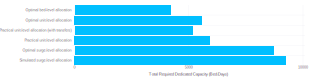

In [116]:
plt = plot(
	reverse(surge_compare),
	x = :beddays,
	y = :scenario,
	Geom.bar(orientation=:horizontal),

	Guide.xlabel("Total Required Dedicated Capacity (Bed-Days)"),
	Guide.ylabel(""),

	style(
		background_color=colorant"white",
		bar_spacing=1mm,
		plot_padding=[0mm, 15mm, 5mm, 0mm];
		fontstyles...,
	),
)
plt |> SVG(32cm, 8cm)
savefig(plt, (32cm, 8cm), output_path, "compare-strategies", "allocation-compare")

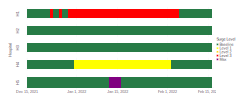

In [117]:
plot_surge_timeline(
	data,
	(;
		capacity_by_surgelevel = capacity_by_surge,
		surge_level = surge_level_timeline,
	),
	nothing,
	show=true,
	save=true,
	folder="compare-strategies",
);

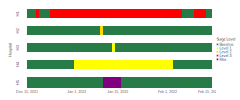

In [118]:
plot_surge_timeline(
	data,
	(;
		capacity_by_surgelevel = capacity_by_surge,
		surge_level = surge_timeline_sim,
	),
	nothing,
	show=true,
	save=true,
	folder="compare-strategies",
);